In [127]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [128]:
df = pd.read_csv('../../data/artists_data.csv', sep='\t')
df.head()

,id,name,genres,followers,popularity
0,1LEtM3AleYg1xabW6CRkpi,Đen,"indie viet, v-pop, vietnamese hip hop, vietnam...",2899329,59
1,3rjcQ5VIWCN4q7UFetzdeO,JustaTee,"v-pop, vietnamese hip hop, vietnamese melodic rap",618216,55
2,5fa13NJjmn2uQ3dxZDi2Ge,Bich Phuong,v-pop,1182922,46
3,0qkGQFUrj8ERPAZcdpa79j,Phuc Du,v-pop,16509,46
4,71Cy7nzbfpuGJAS5FGxm93,Khoi Vu,vietnamese hip hop,25307,43


### <b><u>Question</u>: What are the 10 best rated genres?</b>

In [129]:
song_df = pd.read_csv('../../data/songs_data.tsv', sep='\t')
song_df.head()

,id,name,artist,genres,artist_followers,artist_popularity,markets,album,released_date,album_popularity,duration,explicit,popularity
0,1RDvyOk4WtPCtoqciJwVn8,Dreamers [Music from the FIFA World Cup Qatar ...,"Jung Kook,BTS,FIFA Sound","k-pop boy group,k-pop","5382641,58715441,167875","80,92,77",183,Dreamers [Music from the FIFA World Cup Qatar ...,2022-11-20,81,201391,False,92
1,6A1IbMKwjvXibcrU1sdqKH,Em Là,"MONO,Onionn",NaN,"100123,2809","54,55",182,22,2022-08-18,60,197333,False,62
2,7bFFUPBiF15n8m8RziqS4o,dự báo thời tiết hôm nay mưa,GREY D,v-pop,39690,56,182,dự báo thời tiết hôm nay mưa – Maxi Single,2022-11-22,52,281493,False,62
3,4QjxvzEFwb63NZ1pp3wvHy,Chết Trong Em,Thịnh Suy,"vietnamese singer-songwriter,v-pop",359817,54,183,Chết Trong Em,2022-10-31,50,256663,False,62
4,5p8ThxM2OhJ0igfxkz0Z1q,Wild Flower (with youjeen),RM,k-rap,12005881,81,183,Indigo,2022-12-02,85,273499,False,88


In [130]:
df = song_df.dropna()
df['genres'].update(df['genres'].str.split(','))
genre_popularity = df.explode('genres').loc[:, ['genres', 'popularity']].reset_index(drop=True)
genre_popularity

/tmp/ipykernel_10946/2442345513.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['genres'].update(df['genres'].str.split(','))


,genres,popularity
0,k-pop boy group,92
1,k-pop,92
2,v-pop,62
3,vietnamese singer-songwriter,62
4,v-pop,62
...,...,...
7725,nueva musica mexicana,60
7726,arrocha,60
7727,sertanejo universitario,60
7728,sertanejo pop,60


In [131]:
genre_trend = pd.pivot_table(genre_popularity, values='popularity', index='genres', aggfunc={'genres':'count', 'popularity': np.mean}).round(2)
genre_trend = genre_trend.rename(columns={'genres': 'occurences'})
genre_trend.sort_values(by=['occurences', 'popularity'])

,occurences,popularity
genres,,
alternative pop rock,1,0.00
indie emo,1,0.00
nu disco,1,0.00
queens hip hop,1,0.00
deep euro house,1,1.00
...,...,...
uk pop,247,13.19
vietnamese hip hop,317,41.89
dance pop,351,34.25


<AxesSubplot:xlabel='occurences', ylabel='popularity'>

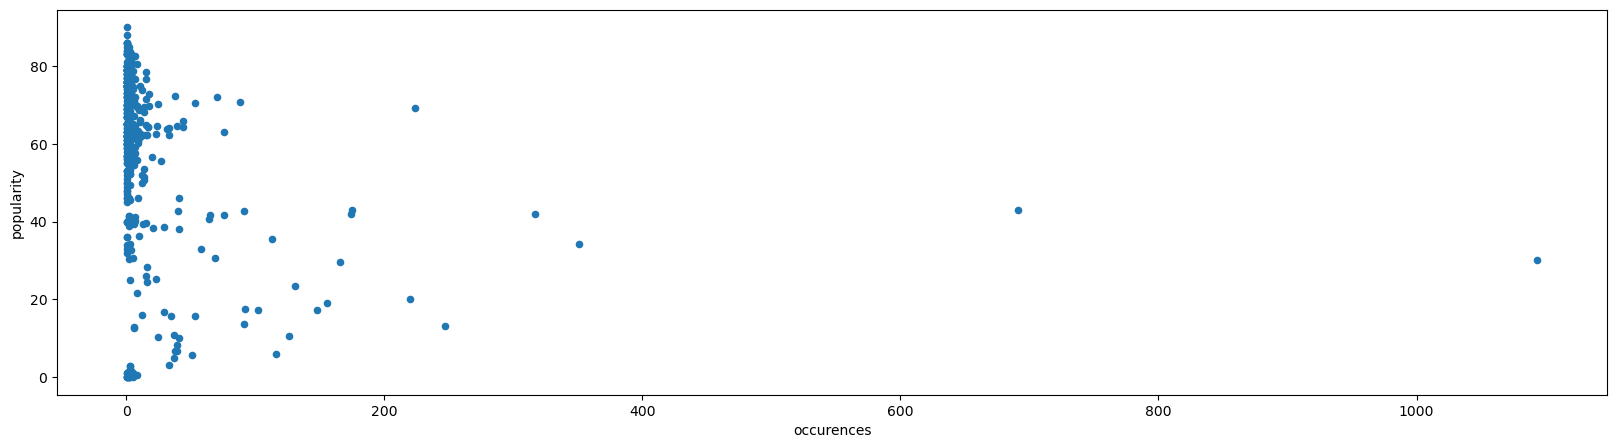

In [132]:
genre_trend.plot.scatter(x='occurences', y='popularity', figsize=(20,5))

In [133]:
genre_trend['occurences'] = (100*(genre_trend['occurences'] - genre_trend['occurences'].min()))/(genre_trend['occurences'].max()-genre_trend['occurences'].min())
genre_trend = genre_trend.rename(columns={'occurences': 'occurences_scaled'})
genre_trend.sort_values(by='occurences_scaled').round(2)

,occurences_scaled,popularity
genres,,
a cappella,0.00,70.00
ninja,0.00,72.00
electronic trap,0.00,76.00
nightcore,0.00,61.00
emoplugg,0.00,73.00
...,...,...
uk pop,22.53,13.19
vietnamese hip hop,28.94,41.89
dance pop,32.05,34.25


In [135]:
genre_trend['rating'] = np.sqrt(genre_trend['occurences_scaled'] * genre_trend['popularity'])
genre_trend.sort_values(by='rating')

,occurences_scaled,popularity,rating
genres,,,
a cappella,0.000000,70.00,0.000000
eau claire indie,0.000000,79.00,0.000000
modern salsa,0.000000,79.00,0.000000
el paso indie,0.000000,69.00,0.000000
modern country rock,0.000000,74.00,0.000000
...,...,...,...
dance pop,32.051282,34.25,33.132407
vietnamese hip hop,28.937729,41.89,34.816684
k-pop,20.421245,69.16,37.581024


In [136]:
genre_trend.nlargest(n=10, columns='rating').round(2)

,occurences_scaled,popularity,rating
genres,,,
pop,100.00,30.07,54.84
v-pop,63.19,42.92,52.08
k-pop,20.42,69.16,37.58
vietnamese hip hop,28.94,41.89,34.82
dance pop,32.05,34.25,33.13
indie viet,15.93,42.95,26.16
vietnamese melodic rap,15.84,41.87,25.76
k-pop boy group,7.97,70.78,23.75
k-pop girl group,6.32,72.07,21.34


<AxesSubplot:ylabel='genres'>

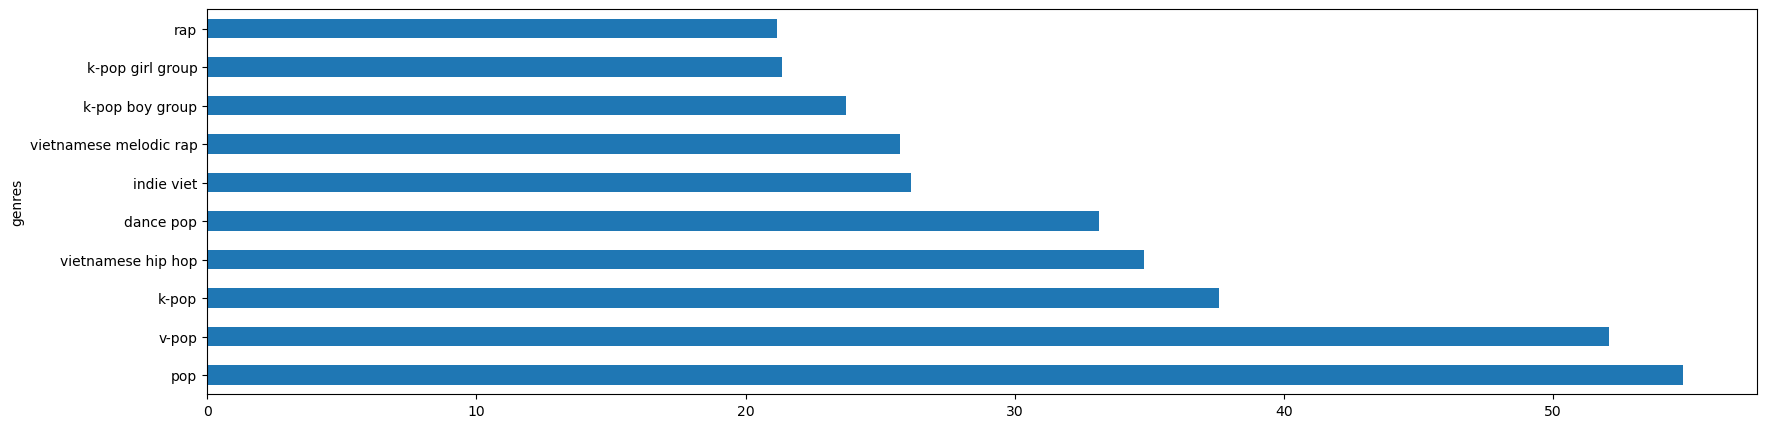

In [144]:
genre_trend.nlargest(n=10, columns='rating')['rating'].plot.barh(figsize=(20, 5))